# Assignment 1

That is the first group assignment for NLP course at CEU. This Assignment is based on the Titanic dataset and lecture notes of the course.

In [99]:
#Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
import os
import seaborn as sns

In [100]:
#Data set already divided in train and test, import both of them
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [101]:
#look which variables I already have
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# 1. Engineer at least two more features to include in your model . For each feature perform visualizations and interpret them

I decided to genereate the following features: title and variable which will describe whether person was alone or not.

# Title

Title can be extracted from the Name column. Title may be important. For example, it can provide information wether a person is married or not and as a result has a higher social status.

In [102]:
train.Name #look how this column Name looks like

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

From the example above I can see that in Name column first goes the name, after which there is a "," sign. Then I want to split every value by "," and take the second value (fist in Python). Then I use the fact that titles are separated by the dot after - I will utilize it to extact titles by splitting by "." and taking the first (zero in Python) value. And I will use strip () to remove all the the leading and trailing spaces from a string..

In [103]:
train['Title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()) # I do feature engineering for both parts of dataset

In [104]:
train['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [105]:
train['Title'].describe()

count     891
unique     17
top        Mr
freq      517
Name: Title, dtype: object

In [106]:
train['Title'].unique() #check wether all titles extracted are indeed titles - looks like

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [107]:
test['Title'].unique() #check for test as well just in case some titles got missed during the split

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

<AxesSubplot:xlabel='Title', ylabel='count'>

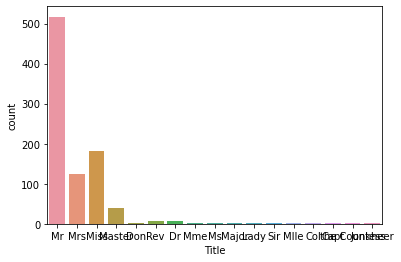

In [108]:
#Now let's look at count plot of Title column
sns.countplot(x ='Title', data=train)


As I can see, some titles are much more often to see. So, it makes sense to group some titles together. 

In [109]:
train['Title'] = train['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
    


<AxesSubplot:xlabel='Title', ylabel='count'>

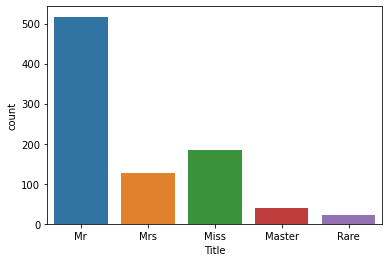

In [110]:
#Let's look at countplot again
sns.countplot(x ='Title', data=train)

As I can see, Mr is still the most common title. Rare titles even combined for a small proportion of the titles present on board

In [111]:
# I also want to look at survival rate by titles
# Survival rate by title group
train.groupby(['Title'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Master,40.0,0.575000,0.500641,0.0,0.0,1.0,1.0,1.0
Miss,185.0,0.702703,0.458309,0.0,0.0,1.0,1.0,1.0
Mr,517.0,0.156673,0.363844,0.0,0.0,0.0,0.0,1.0
Mrs,126.0,0.793651,0.406300,0.0,1.0,1.0,1.0,1.0
Rare,23.0,0.347826,0.486985,0.0,0.0,0.0,1.0,1.0


From the table enough I can say that titles Miss and Mrs were more likely to survive (which is not suprising since they are women). Mr has the lowest chance. And Rare titles also had a law probability to survive

# Family Size and Is Alone

Variable wether the person is alone might be important because perhaps it allowed the passenger to fastly be evacuated because he didn't need to look for his family friends or family and just proceeded to evacuation. To obtain this variable, we first need to create family size variable which is obtained from siblings + spouse variable (SibSp) and parents + children variable (Parch)

In [118]:
#Generate variable family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1 #i add 1 because i need to count person for whom I calculate as well
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1 #do it for test as well

<AxesSubplot:xlabel='FamilySize', ylabel='count'>

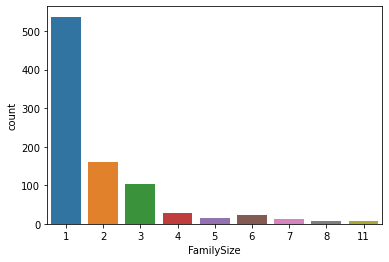

In [119]:
#let's built countplot for this variable
sns.countplot(x = 'FamilySize', data = train)

As we can, see it was most common to be alone. Then we have a high frequency of people whose family size on board is 2-3 and then for other size of family size the frequency is guite low


In [121]:
#How survival looks for different family sizes
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Surprisingly, among those who had a family size of 2-4 the chances to survive were higher. Perhaps it is because those families could afford to buy tickets for family members and were wealthier. Why then with number of family size of 5 and more chances of survival got lower? Perhaps 2-4 family members is also an indicator of middle and upper class. While 5 and more family size shows poorer families.

In [136]:
#Now let's create IsAlone variable if person was on Titanic without family members
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
test['IsAlone'] = 0 #same for test
test.loc[train['FamilySize'] == 1, 'IsAlone'] = 1


<AxesSubplot:xlabel='IsAlone', ylabel='count'>

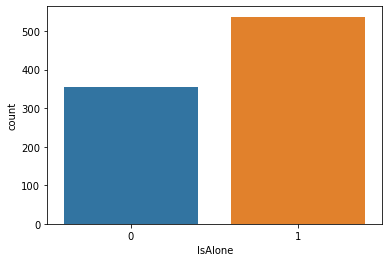

In [140]:
#Let's look at countplot
sns.countplot(x = 'IsAlone', data = train)

There are more people who were on Titanic alone

In [141]:
#Let's look at survival rate
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Indeed, for a person who is alone, the survival chances are higher

# 2. Can you think of possible interactions and polynomials potentially relevant for your model? If yes, do so

In [127]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize'],
      dtype='object')

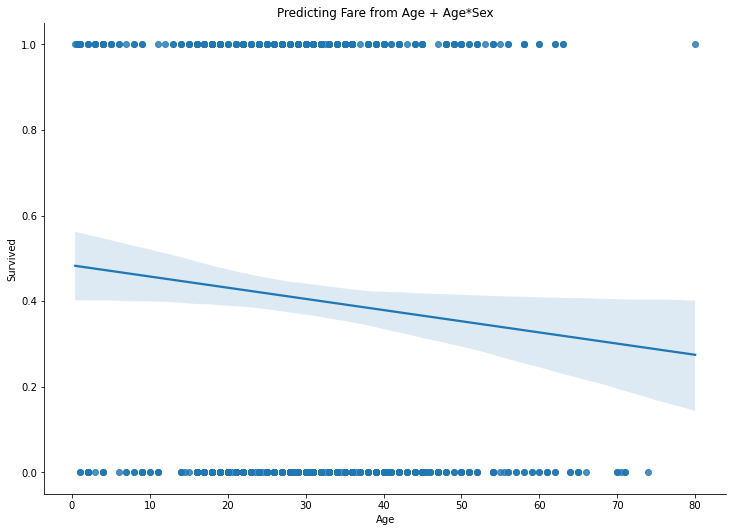

In [139]:
sns.lmplot(y = "Survived", x= "Age", data = train, height=7.27, aspect=11.7/8.27)
ax = plt.gca()
ax.set_title("Predicting Fare from Age + Age*Sex")
plt.show()

Potential interactions:
1) sex and age
2) age and class
3